In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# <font size="6">1. Khai báo tên file</font>

In [2]:
files_file_name = r'D:\projects\Python\BTL\raw_data\files_contents_data.json'
detail_commits_file_name = r'D:\projects\Python\BTL\raw_data\100_detail_commits_per_month_since_2021_data.json'

# <font size="6">2. Mở dữ liệu và làm sạch</font>

<font size="4">2.1. Mở dữ liệu files contents</font>

In [3]:
with open(files_file_name, 'r', encoding='utf-8') as file:
    files_contents_data = json.load(file)
file_contents_df = pd.json_normalize(files_contents_data)
file_contents_df = file_contents_df[['path', 'sha', 'size', 'url', 'type']]

In [4]:
# Lưu dataframe thành file excel
file_contents_df.to_excel(r'D:\projects\Python\BTL\cleaned_data\cleaned_files_contents_data.xlsx')

<font size="4">2.2. Mở dữ liệu detail commit từ năm 2021 để lấy thông tin commit trên mỗi file</font>

In [5]:
with open(detail_commits_file_name, 'r', encoding='utf-8') as file:
    detail_commits_data = json.load(file)
detail_df = pd.json_normalize(detail_commits_data)

In [6]:
columns = ['filename', 'commit.author.name', 'commit.author.date', 'status', 'additions', 'deletions', 'changes']
commits_in_files = pd.DataFrame(columns=columns)
for i in range(len(detail_df)):
    for j in range(len(detail_df.loc[i]['files'])):
        tmp_detail_files = detail_df.loc[i]['files'][j]
        new_row = pd.Series({'filename' : tmp_detail_files['filename'],
                                'commit.author.name': detail_df.loc[i]['commit.author.name'],
                                'commit.author.date' : detail_df.loc[i]['commit.author.date'],
                                'status' : tmp_detail_files['status'],
                                'additions' : tmp_detail_files['additions'],
                                'deletions' : tmp_detail_files['deletions'],
                                'changes' : tmp_detail_files['changes'],
                                })
        commits_in_files = pd.concat([commits_in_files, new_row.to_frame().T], ignore_index=True)


In [7]:
commits_in_files.to_excel(r'D:\projects\Python\BTL\cleaned_data\cleaned_commits_in_file_data.xlsx')

<font size="4">2.3. Tạo dataframe mới lưu total change</font>

In [8]:
file_name_list = list(set(commits_in_files['filename'].to_list()))
columns = ['filename', 'total_commits', 'total_addition', 'total_deletion', 'total_change']
total_change_in_files_df = pd.DataFrame(columns=columns)

for name in file_name_list:
    name_mask = commits_in_files['filename'] == name
    new_row = pd.Series({'filename' : name,
                         'total_commits' : len(commits_in_files[name_mask]),
                         'total_addition' : sum(commits_in_files[name_mask]['additions']),
                         'total_deletion' : sum(commits_in_files[name_mask]['deletions']),
                         'total_change' : sum(commits_in_files[name_mask]['changes'])})
    total_change_in_files_df = pd.concat([total_change_in_files_df, new_row.to_frame().T], ignore_index=True)

# <font size="6">3. Phân tích dữ liệu</font>

<font size="4">3.1. Số file trong repos</font>

In [9]:
num_of_file = len(file_contents_df)
num_of_file

2566

<font size="4">3.2. Tổng kích cỡ của repos là bao nhiêu</font>

In [10]:
size_of_all_files = sum(file_contents_df['size'])
f'{size_of_all_files:,}'

'51,871,203'

<font size="4">3.3. File nào có kích cỡ lớn nhất</font>

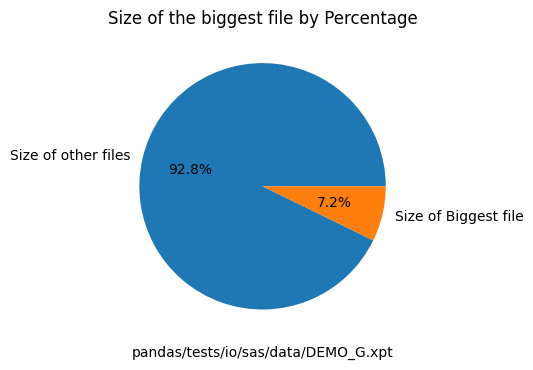

In [11]:
biggest_file = file_contents_df[file_contents_df['size'] == max(file_contents_df['size'])]

sizes = [size_of_all_files - biggest_file['size'].values[0], biggest_file['size'].values[0]]
labels = ['Size of other files', 'Size of Biggest file']

plt.figure(figsize=(4, 4)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.title(f'Size of the biggest file by Percentage')
plt.xlabel(f'{biggest_file['path'].values[0]}')

plt.show()

<font size="4">3.4. Các thông tin thêm về kích cỡ của file</font>

In [12]:
file_contents_df['size'].describe()

count    2.566000e+03
mean     2.021481e+04
std      1.015036e+05
min      0.000000e+00
25%      1.360250e+03
50%      5.046000e+03
75%      1.397975e+04
max      3.753760e+06
Name: size, dtype: float64

<font size="4">3.5. Từ năm 2021, file nào có nhiều commit nhất</font>

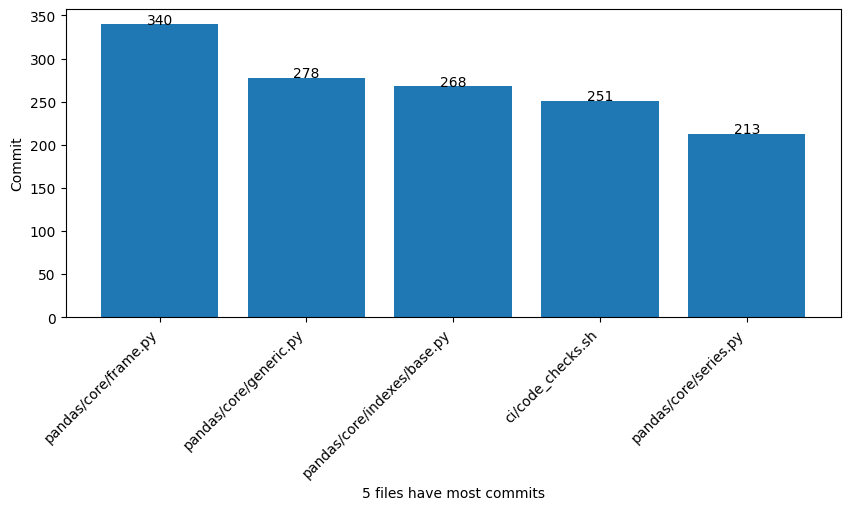

In [13]:
num_of_file = 5
files_have_most_commits = commits_in_files['filename'].value_counts().head(num_of_file)
files_have_most_commits

name = files_have_most_commits.index
value = files_have_most_commits.values

fig, ax = plt.subplots(figsize = (10,4))
ax.bar(name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(num_of_file):
    plt.text(i, value[i] + 0.1, value[i], ha = 'center')
plt.ylabel('Commit')
plt.xlabel(f'{num_of_file} files have most commits')
plt.show()

<font size="4">3.6. Trong 1 tháng cụ thể, file nào có nhiều commit nhất</font>

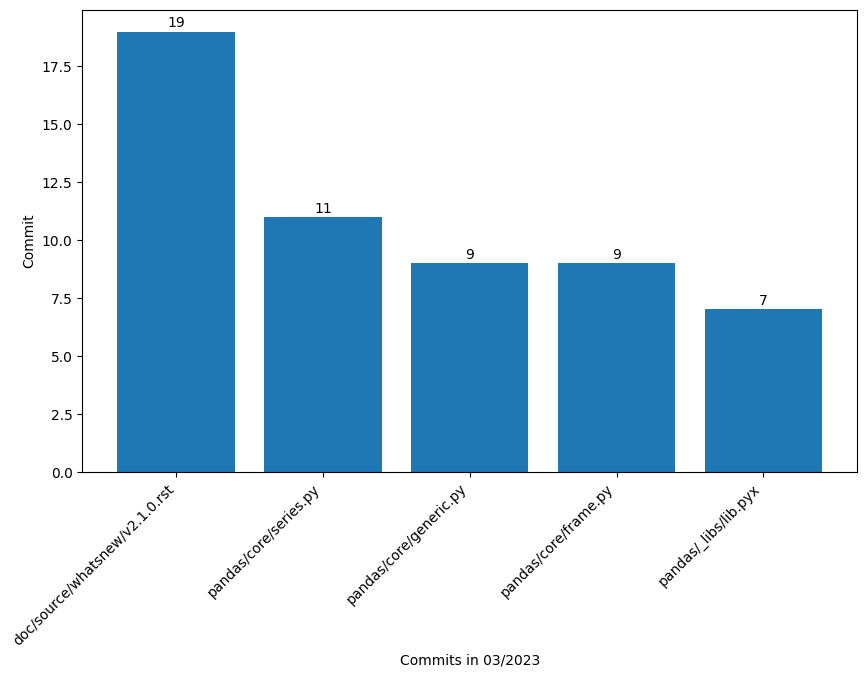

In [14]:
month = '03/2023'
month_search = datetime.strftime(datetime.strptime(month, '%m/%Y'), '%Y-%m')
month_mask = commits_in_files['commit.author.date'].str.contains(month_search)
files_have_most_commit_in_specific_month = commits_in_files[month_mask]['filename'].value_counts().head()

name = files_have_most_commit_in_specific_month.index
value = files_have_most_commit_in_specific_month.values

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar( name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(len(name)):
    plt.text(i, int(value[i]) + 0.2, int(value[i]), ha = 'center')
plt.ylabel('Commit')
plt.xlabel(f'Commits in {month}')
plt.show()


<font size="4">3.7. Số commit trên 1 file trong các tháng từ năm 2021</font>

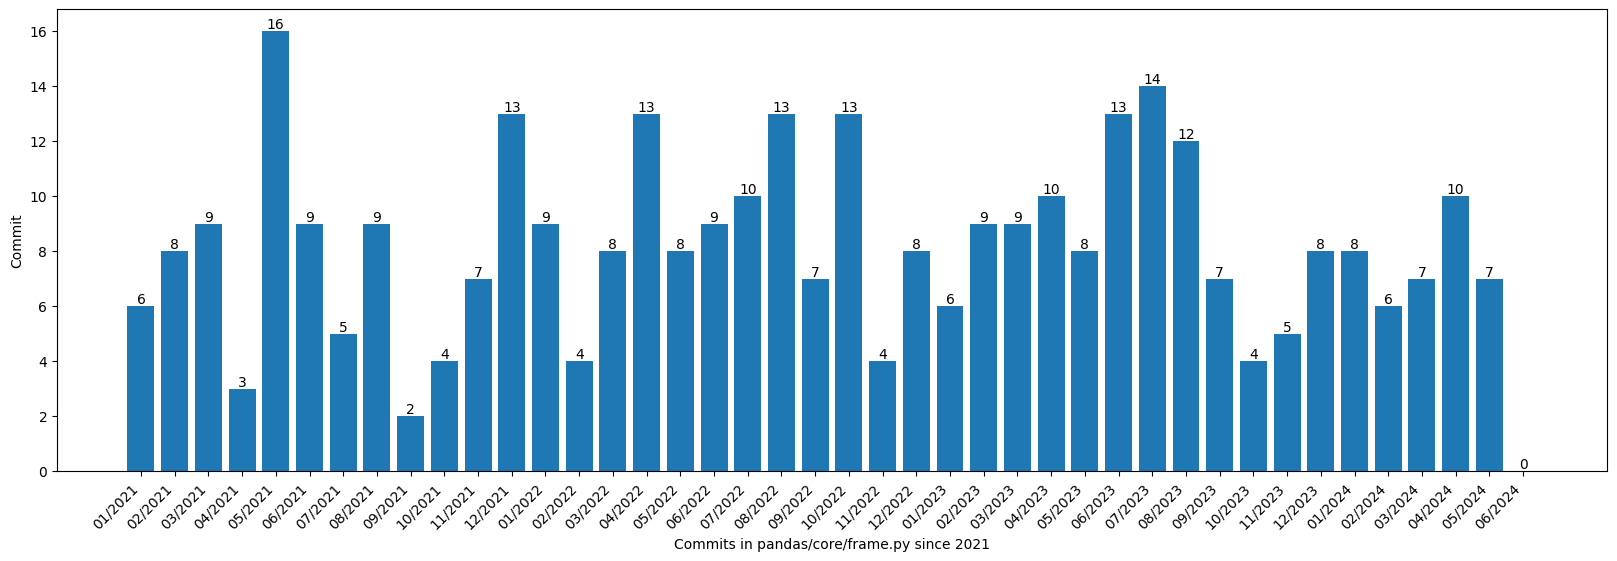

In [15]:
months = []
file_name = 'pandas/core/frame.py'
for year in range(2021, 2025):
    for month in range(1, 13):
        if year == 2024 and month > 6:
            break
        months.append(f"{month:02d}/{year}")
        
month_series = pd.Series(index = months)
for month in months:
    month_search = datetime.strftime(datetime.strptime(month, '%m/%Y'), '%Y-%m')
    month_mask = commits_in_files['commit.author.date'].str.contains(month_search)
    name_mask = commits_in_files['filename'] == file_name
    combined_mask = month_mask & name_mask
    month_series[month] = len(commits_in_files[combined_mask])    

name = month_series.index
value = month_series.values

fig, ax = plt.subplots(figsize = (20, 6))
ax.bar(name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(len(months)):
    plt.text(i, value[i] + 0.1, int(value[i]), ha = 'center')
plt.ylabel('Commit')
plt.xlabel(f'Commits in {file_name} since 2021')
plt.show()

<font size="4">3.8. File nào có tổng lượt Addition nhiều nhất</font>

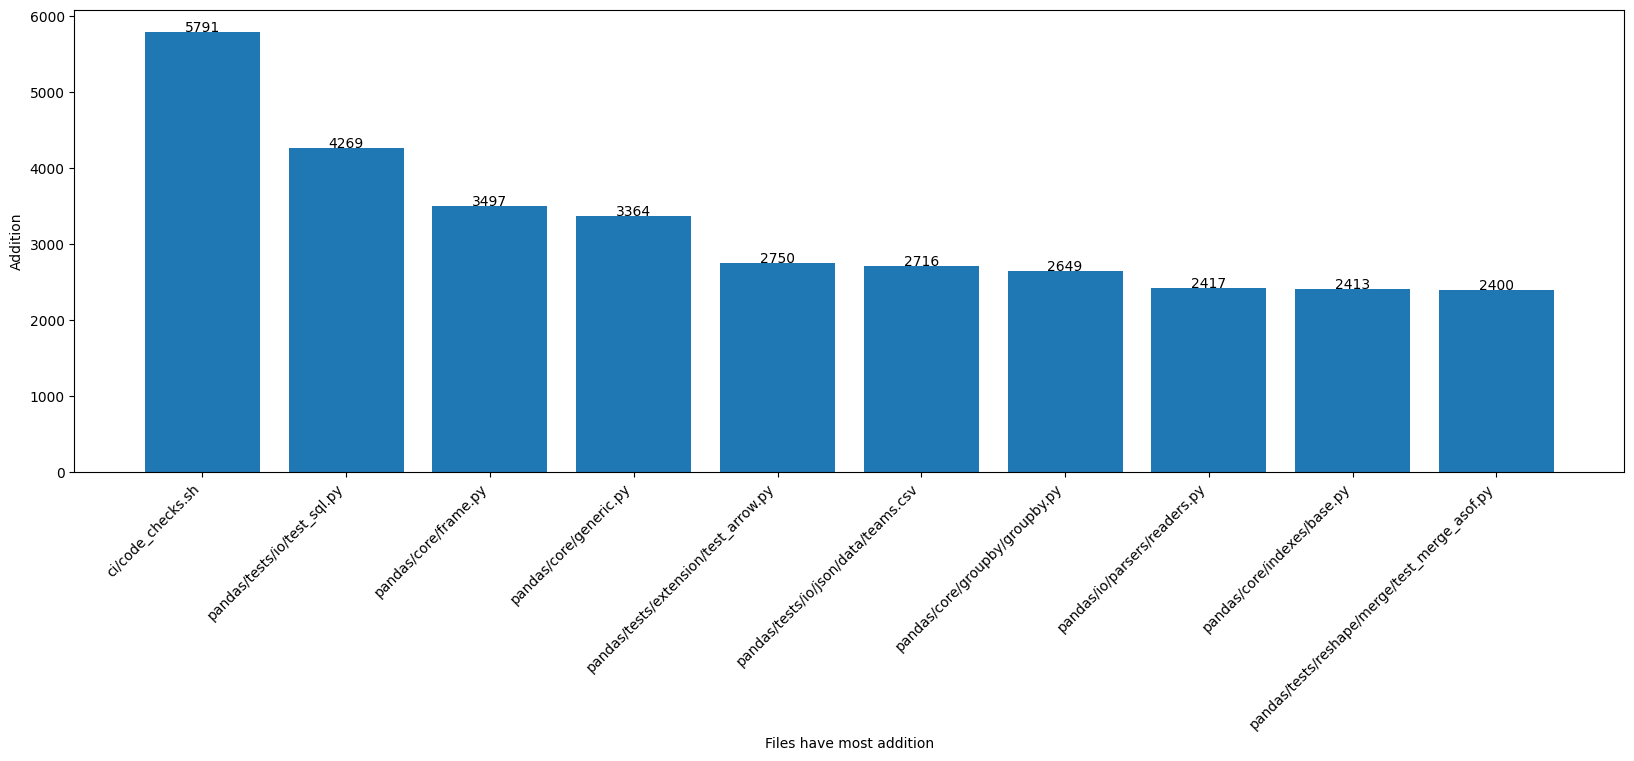

In [16]:
num_of_file = 10
total_change_in_files_sort_by_addition = total_change_in_files_df.sort_values(by = 'total_addition', ascending=False).head(num_of_file)

total_change_in_files_sort_by_addition_series = pd.Series(total_change_in_files_sort_by_addition['total_addition'].to_list(), 
                                                          index=total_change_in_files_sort_by_addition['filename'])

name = total_change_in_files_sort_by_addition_series.index
value = total_change_in_files_sort_by_addition_series.values


fig, ax = plt.subplots(figsize = (20, 6))
ax.bar(name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(num_of_file):
    plt.text(i, value[i] + 0.1, int(value[i]), ha = 'center')
plt.ylabel('Addition')
plt.xlabel('Files have most addition')
plt.show()

<font size="4">3.9. File nào có tổng lượt Deletion nhiều nhất</font>

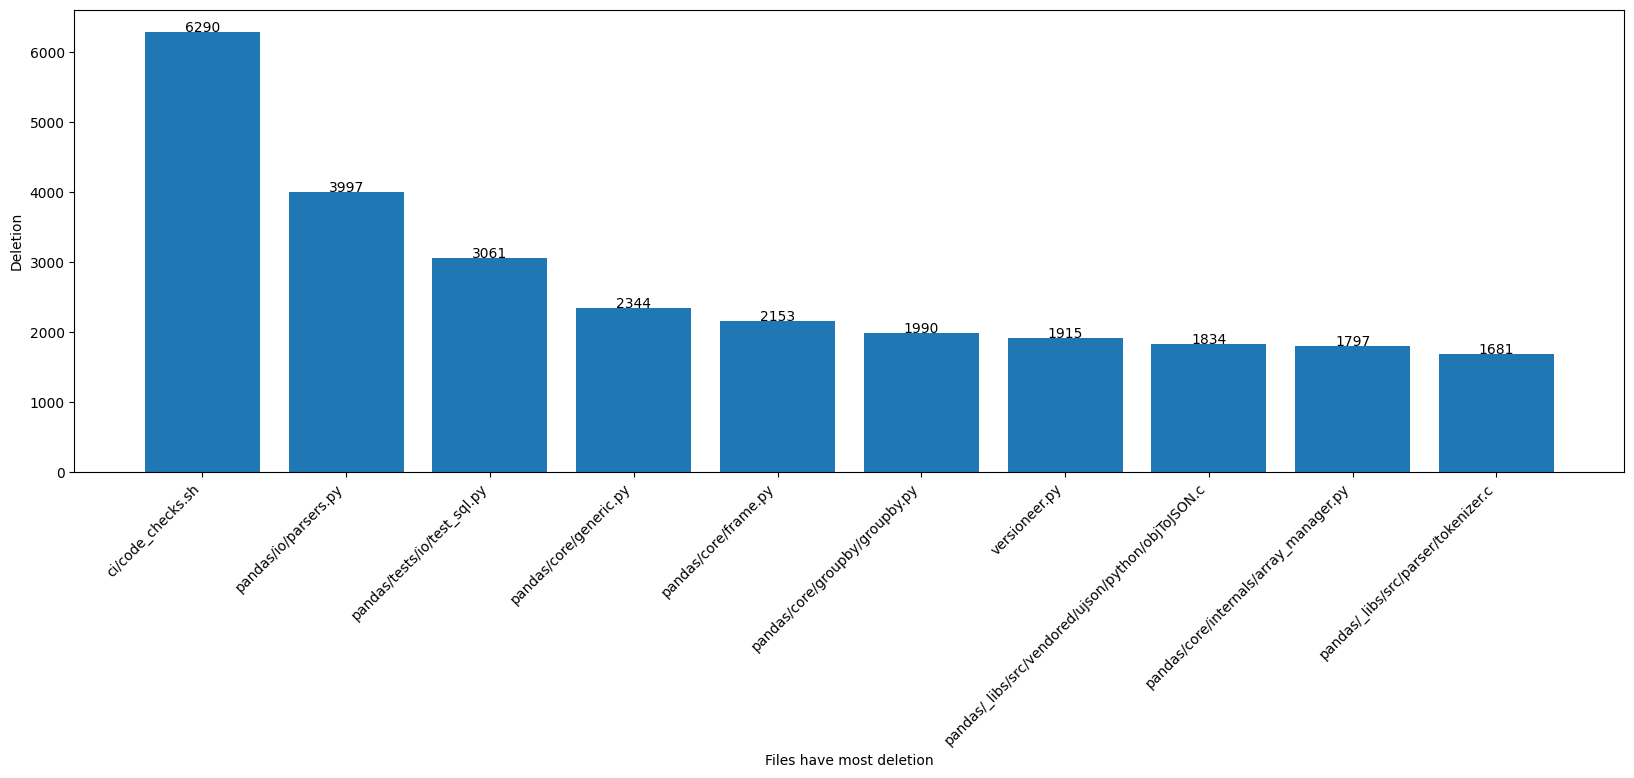

In [17]:
num_of_file = 10
total_change_in_files_sort_by_deletion = total_change_in_files_df.sort_values(by = 'total_deletion', ascending=False).head(num_of_file)

total_change_in_files_sort_by_deletion_series = pd.Series(total_change_in_files_sort_by_deletion['total_deletion'].to_list(), 
                                                          index=total_change_in_files_sort_by_deletion['filename'])

name = total_change_in_files_sort_by_deletion_series.index
value = total_change_in_files_sort_by_deletion_series.values


fig, ax = plt.subplots(figsize = (20, 6))
ax.bar(name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(num_of_file):
    plt.text(i, value[i] + 0.1, int(value[i]), ha = 'center')
plt.ylabel('Deletion')
plt.xlabel('Files have most deletion')
plt.show()

<font size="4">3.10. File nào có tổng lượt Change nhiều nhất</font>

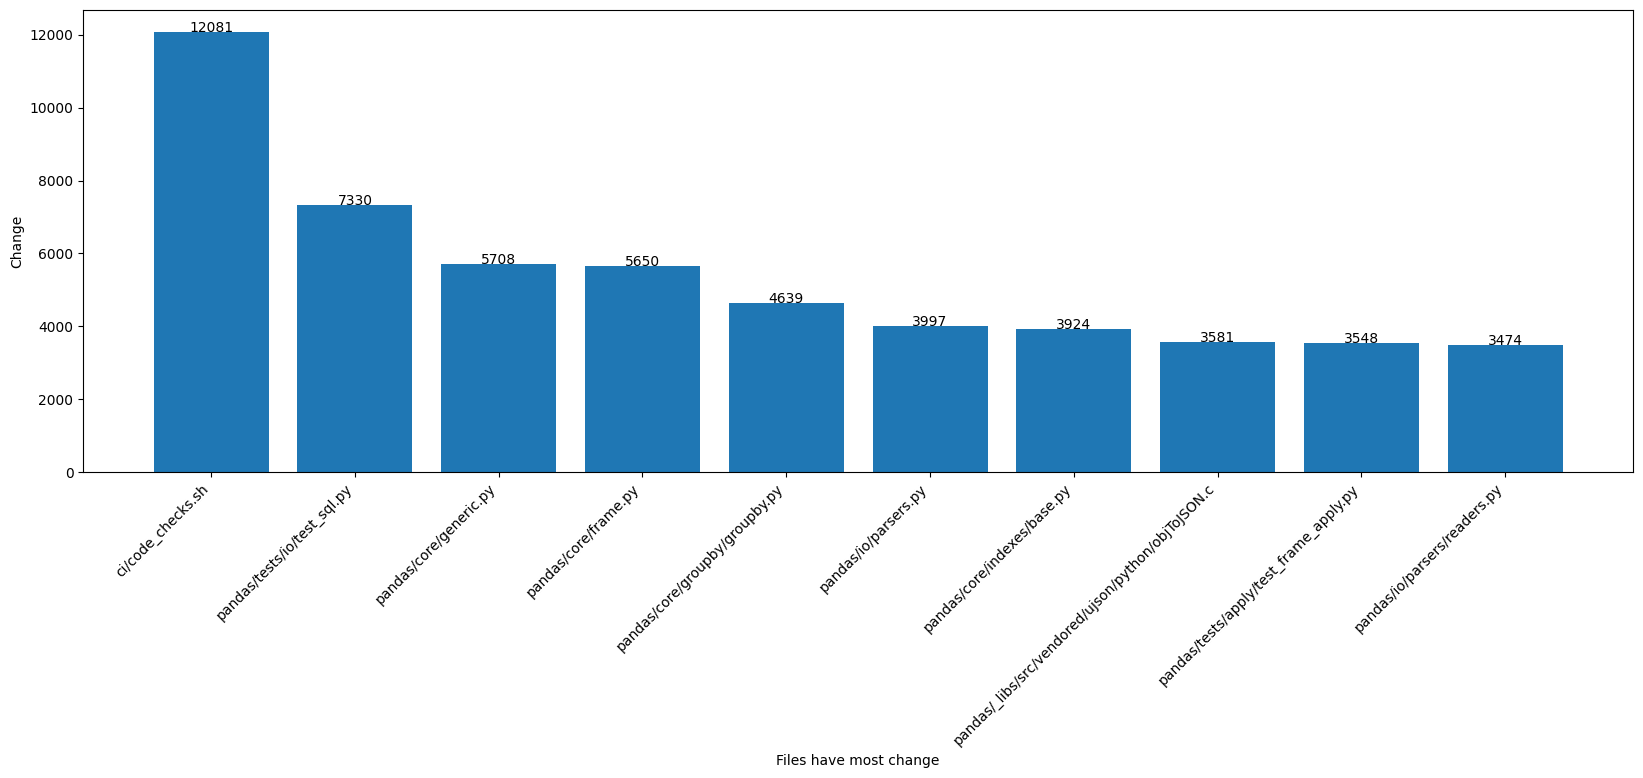

In [18]:
num_of_file = 10
total_change_in_files_sort_by_change = total_change_in_files_df.sort_values(by = 'total_change', ascending=False).head(num_of_file)

total_change_in_files_sort_by_change_series = pd.Series(total_change_in_files_sort_by_change['total_change'].to_list(), 
                                                          index=total_change_in_files_sort_by_change['filename'])

name = total_change_in_files_sort_by_change_series.index
value = total_change_in_files_sort_by_change_series.values


fig, ax = plt.subplots(figsize = (20, 6))
ax.bar(name, value)
ax.set_xticks(name)
ax.set_xticklabels(name, rotation = 45, ha = 'right')
for i in range(num_of_file):
    plt.text(i, value[i] + 0.1, int(value[i]), ha = 'center')
plt.ylabel('Change')
plt.xlabel('Files have most change')
plt.show()